In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
from scipy import stats # 计算概率密度函数

In [2]:
# *****************************推荐系统***********************
# 获取数据
# % Y - num_movies × num_users matrix of user ratings of movies
# % R - num_moveis × num_users matirx, where R(i, j) = 1 if the i-th movie was rated by the j-th user
# % X - num_movies × num_features matirx of movie feature
# % Theta - num_users × num_features matrix of user features, parameter vector of j-th user
movies_mat = sio.loadmat('../data_wu/ex8_movies.mat')
movies_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [3]:
Y, R = movies_mat.get('Y'), movies_mat.get('R')
Y.shape, R.shape

((1682, 943), (1682, 943))

In [6]:
Y[:5, :]

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
R[:5, :]

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
m, u = Y.shape
m, u # 电影数，用户数

(1682, 943)

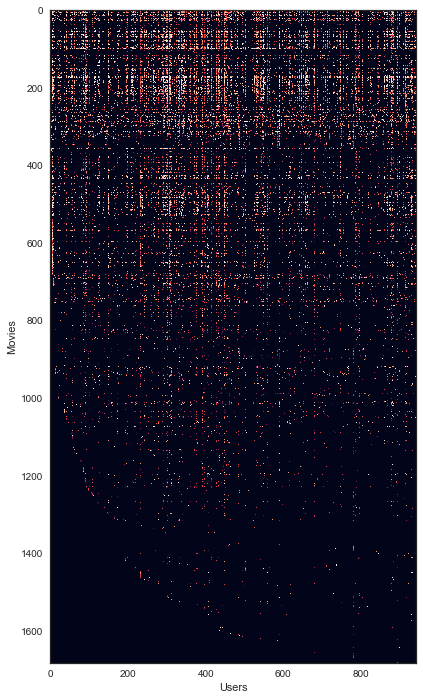

In [5]:
# 将上面的矩阵渲染成图片，进行可视化
fig, ax = plt.subplots(figsize = (12, 12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
# fig.tight_layout()
plt.show()

In [6]:
# parameters for debugging
# 测试用户4 电影5 特征3的话，用这个参数计算代价函数值为22.22
# 用来判断代价函数、编码是否正确
param_mat = sio.loadmat('../data_wu/ex8_movieParams.mat')
param_mat.keys()

X, Theta = param_mat.get('X'), param_mat.get('Theta')
print(X.shape)
print(Theta.shape)

num_features = param_mat.get('num_features')
num_features

(1682, 10)
(943, 10)


array([[10]], dtype=uint8)

In [7]:
Theta[1,:]

array([ 0.50501321, -0.45464846,  0.31746244, -0.11508694,  0.56770367,
        0.81890506,  0.46164876,  1.09306336, -1.20029436, -0.39161676])

In [7]:
# 在使用最优化函数时，初始参数是向量，要将参数转化成向量
# 位置与大小有关
def serialize(X, Theta):
    return np.concatenate((X.ravel(), Theta.ravel()))

def deserialize(param, n_movie, n_user, n_feature):
    """into ndarray of X(1682, 10), Theta(943, 10)"""
    #param到X的大小的位置
    # 以逗号连接换行时，可以不加\，但是return会出错，return需要增加\
    # 并且换行\之后，不能有注释，否则也会出错
    return param[:n_movie * n_feature].reshape(n_movie, n_feature),\
            param[n_movie * n_feature:].reshape(n_user, n_feature) # 剩下的就是Theta大小
           

In [13]:
def cost(param, Y, R, n_features):
    n_movie, n_user = Y.shape
    X, Theta = deserialize(param, n_movie, n_user, n_features)
    
    inner = np.multiply(X @ Theta.T - Y, R)
    
    return np.power(inner, 2).sum() / 2

In [9]:
# test
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, Theta_sub)

cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [22]:
def gradient(param, Y, R, n_features):
    n_movie, n_user = Y.shape
    X, Theta = deserialize(param, n_movie, n_user, n_features)
    
    inner = np.multiply(X @ Theta.T - Y, R)
    
    grad_X = inner @ Theta
    grad_Theta = inner.T @ X
    
    return serialize(grad_X, grad_Theta)

def regularized_cost(param, Y, R, n_features, l= 1):
    reg_term = np.power(param, 2).sum() * (l / 2)
    
    return cost(param, Y, R, n_features) + reg_term

def regularized_gradient(param, Y, R, n_features, l = 1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param
    
    return grad + reg_term

In [23]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [26]:
param = serialize(X, Theta)
regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

In [29]:
# 判断一下梯度向量是否与原来的维度一致

n_movies, n_users= Y.shape

X_grad, Theta_grad = deserialize(regularized_gradient(param, Y, R, 10, l = 1), n_movies, n_users, 10)

# assert是断言的意思，如果为false，则会触发异常
assert X_grad.shape == X.shape
assert Theta_grad.shape == Theta.shape

In [33]:
# 根据自己的评分推荐电影

movie_list = []

with open('../data_wu/movie_ids.txt', encoding = 'latin-1') as f:
    lines = f.readlines()
    for line in lines:
        tokens = line.strip().split(' ') # 以空格分隔
        # print(tokens)
        movie_list.append(' '.join(tokens[1:])) # 去掉前面的行号拼接
        


In [35]:
# movie_list
movie_list = np.array(movie_list)
movie_list

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U81')

In [37]:
# 增加我的评分

ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

Y, R = movies_mat.get('Y'), movies_mat.get('R')

# 原来的数据是943列，现在增加自己的一列，成为944列

Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape



(1682, 944)

In [38]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [40]:
# 推荐电影


n_features = 50
n_movie, n_user = Y.shape
l = 10

# 随机生成参数值
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

In [41]:
param = serialize(X, theta)

# 首先需要将原来数据进行均值归一化处理
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

In [43]:
### training
# 所得的是最优化参数
res = opt.minimize(fun = regularized_cost,
                   x0 = param,
                   args = (Y_norm, R, n_features, l),
                   method = 'TNC',
                   jac = regularized_gradient)




In [51]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

prediction = X_trained @ theta_trained.T

# 需要将归一化之前的行均值再加上
# 得到预测的评分值
my_preds = prediction[:, 0] + Y.mean()

my_preds

array([3.65724159, 2.52103641, 2.29350251, ..., 0.50708523, 0.57596291,
       0.65630742])

In [49]:
# argsort函数返回的是数组值从小到大的索引值
# a[::-1] ### 取从后向前（相反）的元素
idx = np.argsort(my_preds)[::-1]  # Descending order    
idx.shape

(1682,)

In [50]:
# top ten idx
my_preds[idx][:10]

array([4.12533959, 4.04414064, 3.99324503, 3.91902592, 3.81691394,
       3.8155584 , 3.76602244, 3.76322796, 3.75904032, 3.75077128])

In [52]:
# 电影名称
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)


In [2]:
# ******************************** 异常检测 ************************
mat = sio.loadmat('../data_wu/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [4]:
X = mat.get('X')
Xval = mat.get('Xval')
yval = mat.get('yval')

X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

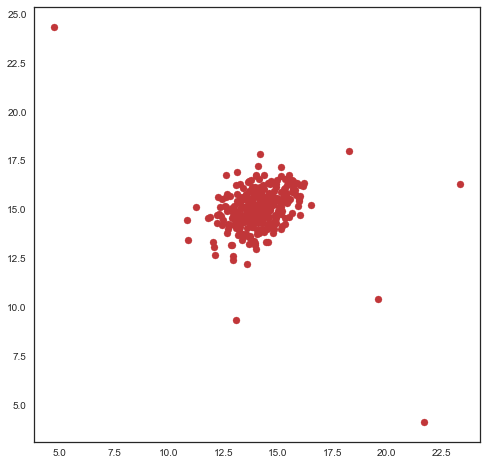

In [6]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(X[:, 0], X[:, 1])
plt.show()

In [7]:
# 从图中可以看到，有几个点是脱离点中心的，这些应该是异常点。通过算法，找到这些异常点
# 需要我们将所有点的每个特征计算高斯分布
def estimate_gaussian(X):
    mu = X.mean(axis = 0)
    sigma = X.var(axis = 0)
    
    return mu, sigma

In [8]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [10]:
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

In [12]:
# 计算高斯模型中数据集特征的概率密度
p = np.zeros((X.shape[0], X.shape[1]))
p[:, 0] = stats.norm(mu[0], sigma[0]).pdf(X[:, 0])
p[:, 1] = stats.norm(mu[1], sigma[1]).pdf(X[:, 1])

p.shape

(307, 2)

In [13]:
# 验证集执行此操作
# 与真实标签组合的概率确定最佳阈值
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:, 0] = stats.norm(mu[0], sigma[0]).pdf(X[:, 0])
pval[:, 1] = stats.norm(mu[1], sigma[1]).pdf(X[:, 1])

pval.shape

(307, 2)

In [14]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1 = (2 * precision * recall ) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [15]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

C:\Users\Administrator.XuanJi-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


(0.05109992785293987, 0.6666666666666667)

In [16]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([147, 170, 300, 301, 301, 303, 303, 304, 305, 305, 306, 306],
       dtype=int64), array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int64))

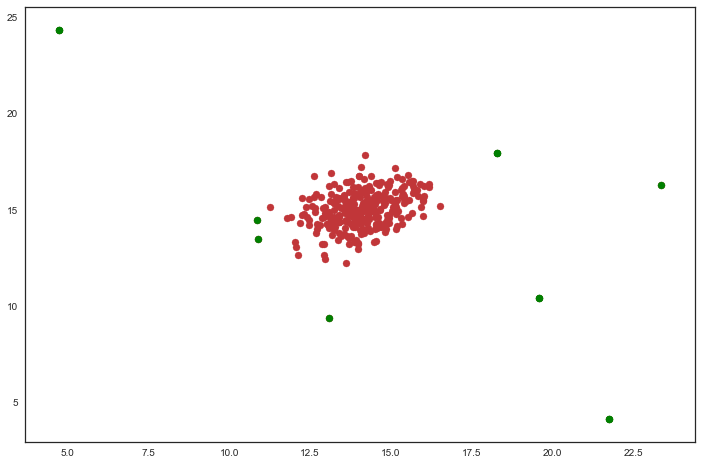

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='g', marker='o')
plt.show()